In [ ]:
import numpy as np
import pandas as pd
import os

### Kears의 Pretrained 모델 로딩 및 모델 구조 확인

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception


In [ ]:
# VGG 모델 불러오기
model = VGG16()
model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# VGG 모델 불러오기 : include_top = Flase : CNN중 classification 영역의 레이어는 제외하고 모델을 가져온다
model = VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')
model.summary

58889256/58889256 [==============================] - 0s 0us/step


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7ad7bd535c00>>

### Keras의 Model도 Functional이다
- 대문자로 써져있으면 대부분 Functional 레이어이다!

In [ ]:
print('model: ', model) # model을 출력해보면 functional 객체임을 확인할 수 있다
print('model output: ', model.output)

model:  <keras.engine.functional.Functional object at 0x7ad7bd535c00>
model output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


### Pretrained 모델 기반으로 CIFAR 10 분류 모델 재생성

In [ ]:
# 이미지 사이즈와 배치 사이즈를 미리 설정해주자
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

# include = False : classifier 층 모두 제거, weight = 'imagenet' : 가져온 모델이 imagenet으로 학습한 가중치를 초기 가중치로 설정

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), include_top=False, weights='imagenet')
bm_output = base_model.output

# basemodel의 output을 입력으로 CIFAR10용 Classification layer를 재구성하자
x = GlobalAveragePooling2D()(bm_output) # 원문에서는 flatten 사용했으나 여기선 GAP 사용
x = Dense(50, activation='relu', name='fc1')(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
## 다른 방식으로 input 표현하기 : input부분을 변수로 따로 작성하기 (더 직관적)
# input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# base_model = VGG16(input_tensor=input_tensor, include_top=False, weight='imagenet')

# model = Model(inputs=input_tensor, outputs=output)
# model.summary()

## 데이터 전처리 및 ImageDataGenerator로 Augmentation 설정 & 학습/검증용 Generator 생성

### 데이터 전처리

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음.
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):

    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)

    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


### Augmentation 설정 & 학습/검증용 Generator 생성

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    # rotation_range=20,
    #zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    #vertical_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

## Keras CNN 모델 생성 함수

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### 모델 생성하기

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
  input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 인풋값 설정
  base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet') # 모델 생성
  bm_output = base_model.output

  # classifier
  x = GlobalAveragePooling2D()(bm_output)
  x = Dense(50, activation='relu', name='fc1')(x)
  output = Dense(10, activation='softmax', name='output')(x)

  # 모델 작동
  model = Model(inputs=input_tensor, outputs=output)
  if verbose:
    model.summary()

  return model

In [ ]:
from keras.optimizers import optimizer

# 모델 객체 생성
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번의 iteration 내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2 로 줄인다
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)

# 10번의 iteration 내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode=10, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = vgg_model.fit(flow_tr_gen, epochs=40,
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 44s 38ms/step - loss: 1.8362 - accuracy: 0.2769 - val_loss: 1.5938 - val_accuracy: 0.3655 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 24s 36ms/step - loss: 1.3103 - accuracy: 0.5050 - val_loss: 1.1529 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 24s 37ms/step - loss: 1.0189 - accuracy: 0.6391 - val_loss: 0.9978 - val_accuracy: 0.6524 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 25s 38ms/step - loss: 0.8552 - accuracy: 0.7042 - val_loss: 0.8536 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 25s 37ms/step - loss: 0.7570 - accuracy: 0.7437 - val_loss: 0.7374 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 25s 38ms/step - loss: 0.6765 - accuracy: 0.7736 - val_loss: 0.6675 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 25s 

In [ ]:
# 테스트 세트에 대한 Generator도 만들어주어 rescale, batch 설정 후 evaluate
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_labels, batch_size=BATCH_SIZE, shuffle=False)
vgg_model.evaluate(flow_test_gen)

157/157 [==============================] - 2s 13ms/step - loss: 1369.1195 - accuracy: 0.1075


[1369.1195068359375, 0.10750000178813934]

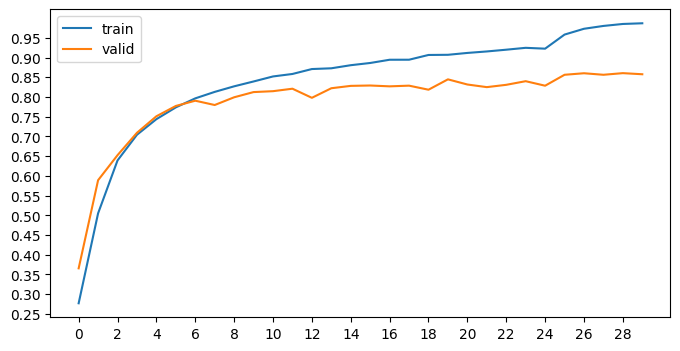

In [ ]:
# 시각화

import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
  plt.figure(figsize=(8,4))
  plt.yticks(np.arange(0, 1, 0.05))
  plt.xticks(np.arange(0, 30, 2))
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='valid')
  plt.legend()


show_history(history)